## Packages #

In [1]:
%matplotlib inline
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from pyds import MassFunction

## The dataset #
The data set is taken from two Gaussian distributions.

In [2]:
data = pd.read_csv('dataset.txt')
data

,x1,x2,Y
0,0.964588,-0.677009,1
1,1.121373,0.278960,1
2,1.491209,0.487741,1
3,1.050732,0.261016,1
4,1.148200,-0.583565,1
...,...,...,...
995,-1.722823,0.152459,2
996,-2.835500,0.950769,2
997,-1.775083,-1.698757,2
998,-0.456117,0.228054,2


In [3]:
C1 = np.array(data[data['Y'].isin([1])][{'x1', 'x2'}])
C2 = np.array(data[data['Y'].isin([2])][{'x1', 'x2'}])
num_mds = C1.shape[0]

## The parameter ##

In [4]:
gamma1 = 0
gamma2 = 0
Beta = 1
alpha_0 = 0.95
sampleNo = 1000

If the parameter num_folds = sampleNo, we call the method leave-one-out.

In [5]:
num_folds = 10 # Cross-validation
X = data[(['x1', 'x2'])]
y = data[(['Y'])]
num_train = int(sampleNo - X.shape[0] / num_folds)
num_test = int(X.shape[0] / num_folds)

## Compute the phi for DS_kNN ##

In [6]:
def phi1(d_s):
    return np.exp(- gamma1 * (d_s ** Beta))

def phi2(d_s):
    return np.exp(- gamma2 * (d_s ** Beta))

## Compute the mean distances for the parameter: dp##

In [7]:
def compute_mean_distances(C):
    dists = np.zeros((num_mds, num_mds))
    M = np.dot(C, C.T)
    tr = np.square(C).sum(axis=1)
    dists = np.sqrt(np.abs(-2 * M + 2 * np.matrix(tr)))
    ds = (np.sum(dists) - np.sum(tr)) / (num_mds ** 2 - num_mds)
    return ds

## Compute the distances ##

In [8]:
def compute_distances(X_test, X_train):
    dists = np.zeros((num_test, num_train))
    M = np.dot(X_test, X_train.T)
    te = np.square(X_test).sum(axis=1)
    tr = np.square(X_train).sum(axis=1)
    dists = np.sqrt(-2 * M + np.matrix(tr) + np.matrix(te).T)
    return dists

## Predict —— kNN ##

In [9]:
def predict_labels(y_train, dists, k):
    y_pred = np.zeros(num_test)
    for i in range(num_test):
        labels = np.matrix(y_train)[np.argsort(dists[i, :])].flatten()
        closest_y = labels[0, 0:k]
        l_c_y = closest_y.tolist()[0]
        c = Counter(l_c_y)
        y_pred[i] = c.most_common(1)[0][0]
    return y_pred

## Predict —— weighted_kNN ##

In [10]:
def predict_labels_weight(y_train, dists, k):
    y_pred = np.zeros(num_test)
    for i in range(num_test):
        closest_y = []
        distances = np.sort(np.matrix(dists)).flatten()[:, 0:k]
        dk = distances[:, k - 1]
        d1 = distances[:, 0]
        delta_d = dk - d1
        ds = (dk - distances) / delta_d
        labels = np.matrix(y_train)[np.argsort(dists[i, :])].flatten()
        closest_y = labels[0, 0:k]
        weights = np.zeros(2)
        for j in range(k):
            if closest_y.tolist()[0][j] == 1:
                weights[0] += ds.tolist()[0][j]
            else:
                weights[1] += ds.tolist()[0][j]
        if weights[0] > weights[1]:
            y_pred[i] = 1
        else:
            y_pred[i] = 2
    return y_pred

## Predict —— DS_kNN ##

In [11]:
def predict_labels_DS(y_train, dists, k):
    y_pred = np.zeros(num_test)
    for i in range(num_test):
        closest_y = []
        distances = np.sort(np.matrix(dists)).flatten()[:, 0:k]
        labels = np.matrix(y_train)[np.argsort(dists[i, :])].flatten()
        closest_y = labels[0, 0:k]
        weights = np.zeros([2, k])
        count1 = 0
        count2 = 0
        for j in range(k):
            if closest_y.tolist()[0][j] == 1:
                count1 += 1
                weights[0][j] = distances.tolist()[0][j]
            else:
                count2 += 1
                weights[1][j] = distances.tolist()[0][j]
        m1 = [1, 0, 0]
        m2 = [0, 1, 0]
        for l in range(k):
            if weights[0][l] != 0:
                m1[0] *= 1 - alpha_0 * phi1(weights[0][l])
            if weights[1][l] != 0:
                m2[1] *= 1 - alpha_0 * phi2(weights[1][l])
        M1 = MassFunction({'1': 1 - m1[0], '2': 0, '12': m1[0]})
        M2 = MassFunction({'1': 0, '2': 1 - m2[1], '12': m2[1]})
        if count1 == 0:
            M = M2
        elif count2 == 0:
            M = M1
        else:
            M = M1 & M2

        if (M.bel({'1'}) > M.bel({'2'})) & (M.pl({'1'}) > M.pl({'2'})):
            y_pred[i] = 1
        if (M.bel({'1'}) < M.bel({'2'})) & (M.pl({'1'}) < M.pl({'2'})):
            y_pred[i] = 2

    return y_pred

In [12]:
dq1 = compute_mean_distances(C1)
dq2 = compute_mean_distances(C2)
gamma1 = 1 / dq1
gamma2 = 1 / dq2

## X Cross-validation ##

In [13]:
k_choices = list(range(2, 26))
X_train_folds = []
y_train_folds = []
X_train_folds = np.array_split(X, num_folds)
y_train_folds = np.array_split(y, num_folds)
k_to_accuracies = {}
k_to_accuracies_w = {}
k_to_accuracies_ds = {}
for k in k_choices:
    for fold in range(num_folds):
        validation_X_test = X_train_folds[fold]
        validation_y_test = y_train_folds[fold]
        temp_X_train = np.concatenate(X_train_folds[:fold] + X_train_folds[fold + 1:])
        temp_y_train = np.concatenate(y_train_folds[:fold] + y_train_folds[fold + 1:])
        temp_dists = compute_distances(validation_X_test, temp_X_train)

        temp_y_test_pred = predict_labels(temp_y_train, temp_dists, k)
        temp_y_test_pred = temp_y_test_pred.reshape((-1, 1))

        temp_y_test_pred_w = predict_labels_weight(temp_y_train, temp_dists, k)
        temp_y_test_pred_w = temp_y_test_pred_w.reshape((-1, 1))

        temp_y_test_pred_ds = predict_labels_DS(temp_y_train, temp_dists, k)
        temp_y_test_pred_ds = temp_y_test_pred_ds.reshape((-1, 1))

        num_correct = np.sum(temp_y_test_pred == validation_y_test)
        num_correct_w = np.sum(temp_y_test_pred_w == validation_y_test)
        num_correct_ds = np.sum(temp_y_test_pred_ds == validation_y_test)

        num_test = validation_X_test.shape[0]

        accuracy = float(num_correct) / num_test
        accuracy_w = float(num_correct_w) / num_test
        accuracy_ds = float(num_correct_ds) / num_test

        k_to_accuracies[k] = k_to_accuracies.get(k, []) + [accuracy]
        k_to_accuracies_w[k] = k_to_accuracies_w.get(k, []) + [accuracy_w]
        k_to_accuracies_ds[k] = k_to_accuracies_ds.get(k, []) + [accuracy_ds]

## Compute the average of error rate ##

In [14]:
k_error_rate = []
k_error_rate_w = []
k_error_rate_ds = []
for k in sorted(k_to_accuracies):
    sum_ac = 0
    for accuracy in k_to_accuracies[k]:
        sum_ac += accuracy
    # print('k = %d, accuracy = %.3f' % (k, sum_ac/num_folds))
    k_error_rate.append(1 - sum_ac/num_folds)

for k in sorted(k_to_accuracies_w):
    sum_ac = 0
    for accuracy in k_to_accuracies_w[k]:
        sum_ac += accuracy
    # print('k = %d, accuracy = %.3f' % (k, sum_ac/num_folds))
    k_error_rate_w.append(1 - sum_ac/num_folds)

for k in sorted(k_to_accuracies_ds):
    sum_ac = 0
    for accuracy in k_to_accuracies_ds[k]:
        sum_ac += accuracy
    # print('k = %d, accuracy = %.3f' % (k, sum_ac/num_folds))
    k_error_rate_ds.append(1 - sum_ac/num_folds)

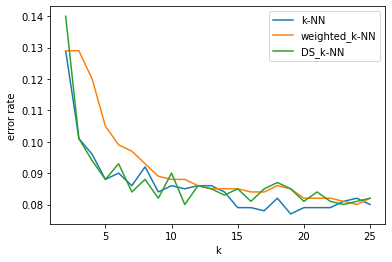

In [15]:
plt.xlabel('k')
plt.ylabel('error rate')
plt.plot(k_choices, k_error_rate)
plt.plot(k_choices, k_error_rate_w)
plt.plot(k_choices, k_error_rate_ds)
plt.legend(['k-NN', 'weighted_k-NN', 'DS_k-NN'])
plt.show()